## 网络中的网络：NiN

- LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。
- AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。或者，可以想象在这个过程的早期使用全连接层。
- 然而，如果使用了全连接层，可能会完全放弃表征的空间结构。
- 网络中的网络（NiN，2013）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机。

### 1、全连接层的问题

全连接层特别占用参数空间，并且带来过拟合。
- 卷积层需要较少的参数：$c_i\times c_o \times k^2$，输入通道数\*输出通道数\*窗口大小；
- 但卷积层后的第一个全连接层的参数：输出通道数\*最终压缩到的大小\*隐藏层的输出维度
  - LeNet：16\*5\*5\*120 = 48k
  - AlexNet：256\*5\*5\*4096 = 26M
  - VGG：512\*7\*7\*4096 = 100M

### 2、NiN块

<img src='https://zh-v2.d2l.ai/_images/nin.svg' style="zoom:60%;" />

将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature），应用全连接层。
- 一个卷积层（窗口形状由用户设置）后面，跟两个不改变通道数的$1\times 1$的卷积层：
  - $1\times 1$的卷积步幅为1，无填充，充当全连接层，聚合各个通道；
  - 每个卷积层后面，都跟一个ReLU。

In [1]:
import torch
from torch import nn
import sys
sys.path.append('..')
import utils
import d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

### 3、NiN网络

- NiN使用窗口形状为$11\times 11$、$5\times 5$和$3\times 3$的NiN块，输出通道数量与AlexNet中的相同。
- 每个NiN块后有一个最大汇聚层，汇聚窗口形状为$3\times 3$，步幅为2。
- 最后放一个**全局**平均汇聚层（global average pooling layer，窗口大小为整张图片大小），生成一个多元逻辑向量（logits）。
- NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。

In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),                       # 将(h, w)的输入，压成(1, 1)的输出，卷积核大小和步幅由算法自适应决定
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [3]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.336, train acc 0.874, test acc 0.884
3186.6 examples/sec on cuda:1


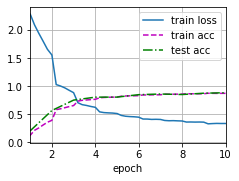

In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data', resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu(1))

### 4、小结

- NiN块使用卷积层加两个1$\times$1的卷积层，后者对每个像素增加了非线性；
- NiN使用全剧平均池化层，来代替VGG和AlexNet中的全连接层：
  - 不容易过拟合，更少的参数个数；

**有个疑问：卷积层的输出通道数/输入通道数，与卷积核的大小，是否有一定关系？**：常见的好像是，通道数加倍同时高宽减半。

另外，换成global average pooling的insight是什么？